In [2]:
# Importing necessary libraries
import requests
import numpy as np
import yfinance as yf
import pandas_ta as ta
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pickle
import warnings

warnings.filterwarnings('ignore')

# Function to fetch and prepare the data
def fetch_and_prepare_data(ticker="SOL-USD", period="max", interval="1d"):
    # Fetch Solana historical daily data from Yahoo Finance
    crypto_df = yf.Ticker(ticker)
    crypto_df = crypto_df.history(period=period, interval=interval)
    crypto_df = pd.DataFrame(crypto_df, columns=['High', 'Low', 'Close', 'Volume'])
    crypto_df.reset_index(inplace=True)
    crypto_df.rename(columns={'Date': 'timestamp'}, inplace=True)
    crypto_df['timestamp'] = pd.to_datetime(crypto_df['timestamp'])
    crypto_df.set_index('timestamp', inplace=True)
    crypto_df.index = crypto_df.index.tz_localize(None)  # Make the index timezone-naive

    # Ensure the data has a consistent daily frequency by resampling
    crypto_df = crypto_df.resample('D').ffill()

    # Fetch Fear and Greed Index historical data
    response = requests.get("https://api.alternative.me/fng/?limit=0&format=json").json()['data']
    fear_greed_df = pd.DataFrame(response, columns=['timestamp', 'value'])
    fear_greed_df['timestamp'] = pd.to_numeric(fear_greed_df['timestamp'])
    fear_greed_df['timestamp'] = pd.to_datetime(fear_greed_df['timestamp'], unit='s')
    fear_greed_df.set_index('timestamp', inplace=True)
    fear_greed_df.rename(columns={'value': 'fear_greed_index'}, inplace=True)
    fear_greed_df.index = fear_greed_df.index.tz_localize(None)  # Make the index timezone-naive

    # Ensure the Fear and Greed Index data has a consistent daily frequency by resampling
    fear_greed_df = fear_greed_df.resample('D').ffill()

    # Merge the two datasets based on their dates
    df = crypto_df.merge(fear_greed_df, how='left', left_index=True, right_index=True)
    df.dropna(inplace=True)

    return df

# Function to add technical indicators
def add_Technical_Indicators(df):
    df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()
    df.ta.macd(close='Close', fast=12, slow=26, signal=9, append=True)
    df.rename(columns={'MACD_12_26_9': 'macd_line', 'MACDs_12_26_9': 'macd_signal',
                       'MACDh_12_26_9': 'macd_hist'}, inplace=True)
    df['RSI_7'] = ta.rsi(df['Close'], length=7)
    df['OBV'] = ta.obv(df['Close'], df['Volume'])
    df['CCI'] = ta.cci(df['High'], df['Low'], df['Close'], length=20)
    df['Momentum'] = ta.mom(df['Close'], length=10)
    df['Awesome_Oscillator'] = ta.ao(df['High'], df['Low'])
    df.dropna(inplace=True)
    return df


# Add the 'Prediction' column and set it to 1 if the price is expected to go up or 0 for the d number of days in the future
def add_target_column(df, d):    
    df['Prediction'] = (df['Close'].shift(-d) > df['Close']).astype(int)
    df.dropna(inplace=True)
    return df


# Selection of features
features = ['EMA_200', 'macd_line', 'RSI_7', 'OBV', 'Momentum', 'CCI', 'Awesome_Oscillator', 'fear_greed_index']

# Function to create sequences of specified number of days
def create_sequences(df, window_size):
    sequences = []
    targets = []
    for i in range(len(df) - window_size):
        sequence = df.iloc[i:i + window_size]
        target = df.iloc[i + window_size]['Prediction']
        sequences.append(sequence[features].values)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Prepare the data
df = fetch_and_prepare_data()

# Add technical indicators
add_Technical_Indicators(df)

# add target column for predictions
add_target_column(df, 3)

# Create sequences for training
window_size = 10
X, y = create_sequences(df, window_size)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Flatten the sequences for Random Forest
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Create and train the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, oob_score=True, criterion='gini',
                                  random_state=10, bootstrap=True)
rf_model.fit(X_train_flat, y_train)


RandomForestClassifier(oob_score=True, random_state=10)

In [37]:
X[1]

array([[0.8621765659983978, -0.03789487581307249, 42.41527504638127,
        47387312.0, -0.09837299585342407, -81.1603306987474,
        -0.11169070373563206, '40'],
       [0.859167366211919, -0.03736895716618038, 39.927702902793385,
        45537242.0, -0.0820850133895874, -79.40305517706923,
        -0.1018757497563082, '44'],
       [0.8565798304373368, -0.03339058567895703, 53.34551029157137,
        47837651.0, -0.023463964462280273, -43.96340444626391,
        -0.08528281467802379, '41'],
       [0.8541560411635988, -0.028786750484114165, 57.2683850920237,
        50774079.0, 1.1026859283447266e-05, -12.64155117386248,
        -0.062431890999569584, '40'],
       [0.8521512051900855, -0.021686265675893046, 66.63338847945937,
        54088438.0, 0.047748029232025146, 24.606367731777752,
        -0.04025125521070816, '50'],
       [0.8498855615708196, -0.018126920198518803, 56.38248087584355,
        51708175.0, 0.019927024841308594, 13.096098164744955,
        -0.025890424321679

In [39]:
y[1]

1

In [33]:
df

,High,Low,Close,Volume,fear_greed_index,EMA_200,macd_line,macd_hist,macd_signal,RSI_7,OBV,CCI,Momentum,Awesome_Oscillator,Prediction
timestamp,,,,,,,,,,,,,,,
2020-05-13,0.564874,0.518038,0.550532,2326446,41,0.865122,-0.038969,-0.015268,-0.023700,35.589670,4.533942e+07,-121.782692,-0.129003,-0.116300,1
2020-05-14,0.580946,0.550110,0.569118,2047897,40,0.862177,-0.037895,-0.011356,-0.026539,42.415275,4.738731e+07,-81.160331,-0.098373,-0.111691,1
2020-05-15,0.574620,0.547093,0.559752,1850070,44,0.859167,-0.037369,-0.008664,-0.028705,39.927703,4.553724e+07,-79.403055,-0.082085,-0.101876,1
2020-05-16,0.606534,0.554361,0.599120,2300409,41,0.856580,-0.033391,-0.003748,-0.029642,53.345510,4.783765e+07,-43.963404,-0.023464,-0.085283,1
2020-05-17,0.640196,0.589175,0.612989,2936428,40,0.854156,-0.028787,0.000684,-0.029471,57.268385,5.077408e+07,-12.641551,0.000011,-0.062432,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-08,163.025909,142.019928,162.930740,5385642745,20,139.279164,-2.942554,-3.231497,0.288943,57.274744,9.018630e+10,-45.212224,-19.849854,-17.086093,0
2024-08-09,163.249481,151.226135,156.457214,3217916997,48,139.450090,-2.608202,-2.317716,-0.290486,50.785679,8.696839e+10,-36.783772,-22.649979,-13.992939,0
2024-08-10,158.586060,152.873047,153.959167,1662980960,40,139.594459,-2.515796,-1.780248,-0.735548,48.320995,8.530541e+10,-39.551065,-17.866989,-8.358866,0


In [4]:
# Display the shapes of the training and testing sets
print(f'X_train shape: {X_train_flat.shape}')
print(f'X_test shape: {X_test_flat.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (1234, 80)
X_test shape: (309, 80)
y_train shape: (1234,)
y_test shape: (309,)


In [6]:
# Make a prediction for the next day using the last 30 days
last_10_days = df.tail(window_size)[features].values
last_10_days = last_10_days.reshape(1, -1)  # Reshape for prediction
next_3day_prediction = rf_model.predict(last_10_days)
print(f"Prediction for the next 3days: {'Up' if next_3day_prediction[0] == 1 else 'Down'}")

Prediction for the next 3days: Down


In [8]:
# Evaluate the model
y_pred = rf_model.predict(X_test_flat)
y_prob = rf_model.predict_proba(X_test_flat)[:, 1]

accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Random Forest model Accuracy: {accuracy:.2f} %")
# Calculate Brier score for Random Forest
rf_brier_score = brier_score_loss(y_test, y_prob)
print(f'Random Forest Brier Score: {rf_brier_score:.4f}')
# Print the Random Forest out-of-bag error
rf_oob_error = 1 - rf_model.oob_score_
print(f'Random Forest Out-Of-Bag Error: {rf_oob_error:.4f}')

Random Forest model Accuracy: 75.08 %
Random Forest Brier Score: 0.1858
Random Forest Out-Of-Bag Error: 0.3306


In [10]:
# Print the classification report for Random Forest
rf_report = classification_report(y_test, y_pred, output_dict=True)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.73      0.74       150
           1       0.75      0.77      0.76       159

    accuracy                           0.75       309
   macro avg       0.75      0.75      0.75       309
weighted avg       0.75      0.75      0.75       309



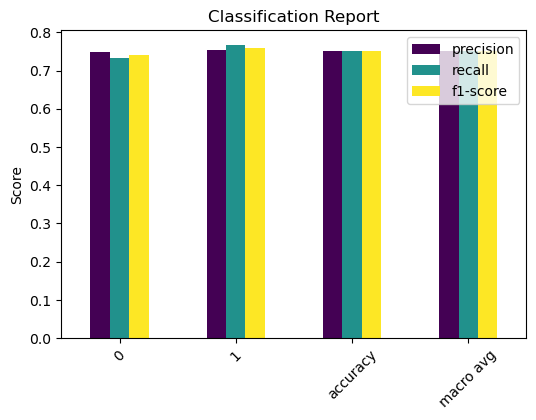

In [12]:
# Convert the classification report to a DataFrame
df_report = pd.DataFrame(rf_report).transpose()

# Plot the bar chart
df_report.iloc[:-1, :-1].plot(kind='bar', figsize=(6, 4), colormap='viridis')
plt.title("Classification Report")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

Random Forest Confusion Matrix:
[[110  40]
 [ 37 122]]


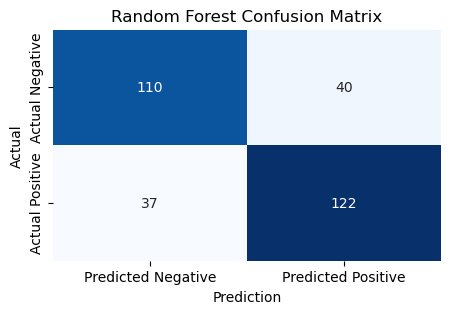

In [14]:
# Confusion matrix for Random Forest
rf_conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Random Forest Confusion Matrix:\n{rf_conf_matrix}')

# Visualize confusion matrix for Random Forest
plt.figure(figsize=(5, 3))
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

Random Forest Feature Importances:
                     Importance
RSI_7                 0.155005
CCI                   0.143334
Momentum              0.131324
fear_greed_index      0.125113
Awesome_Oscillator    0.124917
OBV                   0.109892
EMA_200               0.106601
macd_line             0.103815


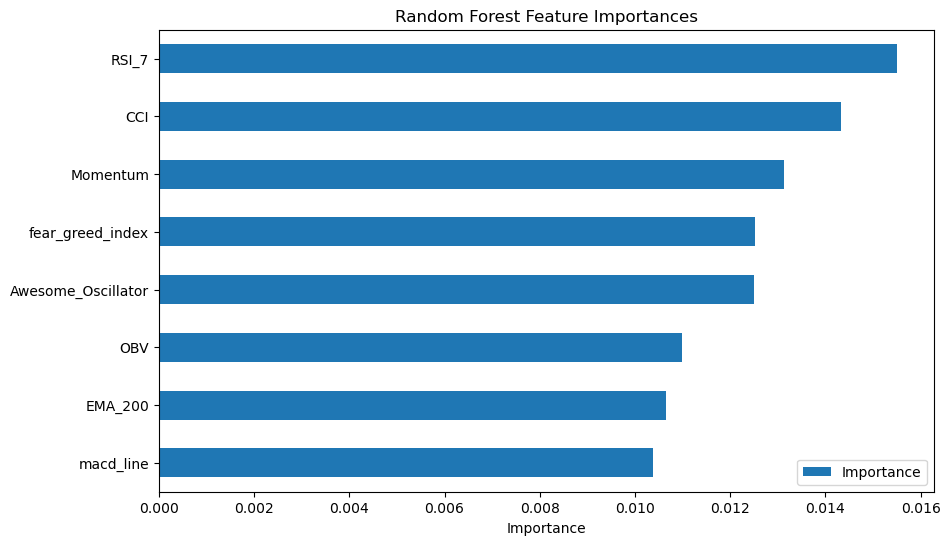

In [16]:
# Reshape the feature importances to match the original features
reshaped_importances = rf_model.feature_importances_.reshape(10, -1)

# Average across time steps
average_importances = np.mean(reshaped_importances, axis=0)

# Create a DataFrame and sort by importance
rf_feature_importances = pd.DataFrame(average_importances, index=features, columns=['Importance']).sort_values(by='Importance', ascending=False)
print("Random Forest Feature Importances:\n", rf_feature_importances  * 10)

# Plot feature importances
rf_feature_importances.plot(kind='barh', figsize=(10, 6), title='Random Forest Feature Importances')
plt.xlabel('Importance')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


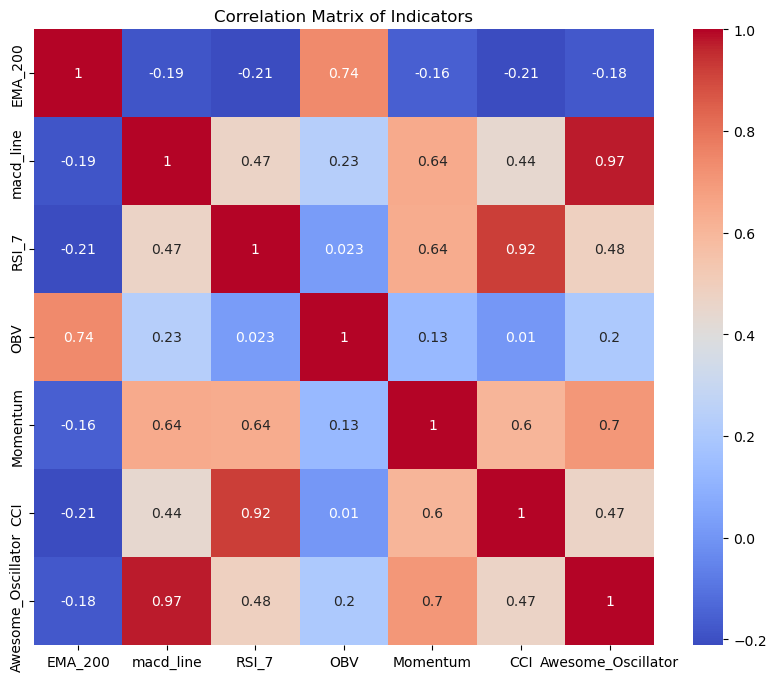

In [18]:
# Correlation matrix
features = ['EMA_200', 'macd_line', 'RSI_7', 'OBV', 'Momentum', 'CCI', 'Awesome_Oscillator']
correlation_matrix = df[features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Indicators')
plt.show()

Random Forest ROC AUC: 0.819


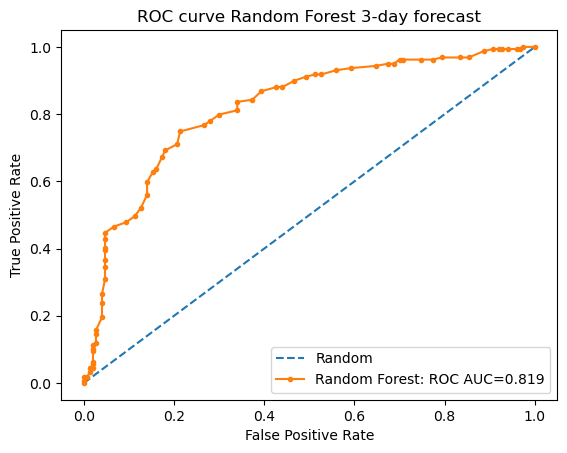

In [20]:
# Function to plot ROC curve
def plot_roc_curve(y_test, model_probs, model_name):
    random_probs = [0 for _ in range(len(y_test))]
    # calculate AUC
    model_auc = roc_auc_score(y_test, model_probs)
    # summarize score
    print(f'{model_name} ROC AUC: {model_auc:.3f}')
    # calculate ROC Curve
    random_fpr, random_tpr, _ = roc_curve(y_test, random_probs)
    model_fpr, model_tpr, _ = roc_curve(y_test, model_probs)
    # Plot the roc curve for the model and the random model line
    plt.title(f'ROC curve {model_name} 3-day forecast')
    plt.plot(random_fpr, random_tpr, linestyle='--', label='Random')
    plt.plot(model_fpr, model_tpr, marker='.', label=f'{model_name}: ROC AUC={model_auc:.3f}')
    # Create labels for the axis
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend(loc="lower right")
    # show the plot
    plt.show()

    
# Plot ROC curves
plot_roc_curve(y_test, y_prob, 'Random Forest')

In [22]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [1, 2, 5],
    'bootstrap': [True, False],
    'oob_score': [True],
}
# Initialize GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, scoring='accuracy', n_jobs=-1, verbose=1, cv=3)
# Fit GridSearchCV to the data
grid_search.fit(X_train_flat, y_train)
best_model = grid_search.best_estimator_
print(f'Best Parameters: {grid_search.best_params_}')
final_model = best_model

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150, 'oob_score': True}


In [24]:
# final evaluation
final_pred = final_model.predict(X_test_flat)
final_prob = final_model.predict_proba(X_test_flat)[:, 1]


accuracy = accuracy_score(y_test, final_pred) * 100
print(f"Random Forest model Accuracy after tuning: {accuracy:.2f} %")
# Calculate Brier score for Random Forest
rf_brier_score = brier_score_loss(y_test, final_prob)
print(f'Random Forest Brier Score after tuning: {rf_brier_score:.4f}')
# Print the Random Forest out-of-bag error
rf_oob_error = 1 - final_model.oob_score_
print(f'Random Forest Out-Of-Bag Error: {rf_oob_error:.4f}')

Random Forest model Accuracy after tuning: 76.70 %
Random Forest Brier Score after tuning: 0.1915
Random Forest Out-Of-Bag Error: 0.3233


In [29]:
# Save the trained model
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)
    
print("Model saved to rf_model.pkl")

Model saved to rf_model.pkl
